# Spain Elections Sentiment Analysis

## Menu

+ [Spanish](#Spanish)
    + [Paquetes](#Paquetes)
    + [Carga de datasets](#Carga-de-datasets)
    + [Exploración](#Exploración)
    + [Pre-procesamiento](#Pre-procesamiento)
+ [English](#English)

## Spanish

### Paquetes

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import re 
import string
import nltk
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

### Carga de datasets

Vamos a cargar los archivos csv generados desde el archivo "twitter_elecciones_espana_2019_v2" en R con el fin de procesarlos en Python. 

In [7]:
result0204 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0204.csv', encoding="latin1")
result0304 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0304.csv', encoding="latin1")
result0404 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0404.csv', encoding="latin1")
result0504 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0504.csv', encoding="latin1")
result0604 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0604.csv', encoding="latin1")
result0704 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0704.csv', encoding="latin1")
result1004 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/1004.csv', encoding="latin1")

In [8]:
result = pd.concat([result0204, result0304, result0404, result0504, result0604, result0704, result1004])

### Exploración

In [9]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320415 entries, 0 to 47061
Data columns (total 17 columns):
Unnamed: 0       320415 non-null int64
text             320415 non-null object
favorited        320415 non-null bool
favoriteCount    320415 non-null int64
replyToSN        11931 non-null object
created          320415 non-null object
truncated        320415 non-null bool
replyToSID       9824 non-null float64
id               320415 non-null int64
replyToUID       11931 non-null float64
statusSource     320415 non-null object
screenName       320415 non-null object
retweetCount     320415 non-null int64
isRetweet        320415 non-null bool
retweeted        320415 non-null bool
longitude        77 non-null float64
latitude         77 non-null float64
dtypes: bool(4), float64(4), int64(4), object(5)
memory usage: 35.4+ MB


Podemos comprobar que existen variables sin registros y en total contamos con __320415__ tweets para analizar.

In [11]:
result.head(3)

,Unnamed: 0,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
0,1,RT @FmartineL: Reparar a las vctimas de la gue...,False,0,NaN,2019-04-02 23:34:23,False,NaN,1113223180431372289,NaN,"<a href=""http://twitter.com/download/android"" ...",muniesalap,90,True,False,NaN,NaN
1,2,RT @POCHY1971: Esperando a encontrar algo sobr...,False,0,NaN,2019-04-02 23:19:04,False,NaN,1113219324632883200,NaN,"<a href=""http://twitter.com/download/android"" ...",Tarrega20049572,34,True,False,NaN,NaN
2,3,RT @FmartineL: La nica garanta que tiene este ...,False,0,NaN,2019-04-02 23:06:03,False,NaN,1113216049070202880,NaN,"<a href=""http://twitter.com/download/android"" ...",coboortiz99,55,True,False,NaN,NaN


In [14]:
result.text.head(5)

0    RT @FmartineL: Reparar a las vctimas de la gue...
1    RT @POCHY1971: Esperando a encontrar algo sobr...
2    RT @FmartineL: La nica garanta que tiene este ...
3    RT @gomezdcelis: Tienes el poder de cambiar la...
4    RT @gomezdcelis: Tienes el poder de cambiar la...
Name: text, dtype: object

In [18]:
result.text.iloc[1]

'RT @POCHY1971: Esperando a encontrar algo sobre #sosprisiones en los #110compromisosPSOE. Me est quedando claro q #PsoeDejaMorirPrisiones.'

In [19]:
result.text.iloc[0]

'RT @FmartineL: Reparar a las vctimas de la guerra y el franquismo, sacar a los cadveres de las fosas y las cunetas no es una cuestin de'

De los anteriores ejemplos podemos notar que algunas palabras presentan problemas, específicamente, las palabras que tienen tildes y ñ.

Revisando el código en R, al parecer el problema se genera al momento de crear los RDS y de transformar los caracteres a ASCII, para trabajo a futuro se procederá a cargar los dataframes a csv puros con el fin de procesarlos en este notebook.

_¿cuantas categorias y datos tiene la variable favorite?_

In [20]:
pd.crosstab(result.favorited, result.favorited)

favorited,False
favorited,
False,320415


Todos los registros tienen valores _False_

_¿Cuantos hashtags fueron utilizados en todos los tweets?_

In [21]:
hashtags_array = []

for i in result.text:
    for t in i.strip("#").split():
        if t.startswith("#"):
            if t in hashtags_array:
                pass
            else:
                hashtags_array.append(t)
len(hashtags_array)

8538

En total se utilizaron __8538 hashtags__

_¿cuantas llamadas a cuentass (@) se hicieron en todos los tweets?_

In [22]:
arroba_array = []

for i in result.text:
    for t in i.strip("@").split():
        if t.startswith("@"):
            if t in arroba_array:
                pass
            else:
                arroba_array.append(t)
len(arroba_array)

14504

En total se llamaron a __14504 cuentas__

## Pre-procesamiento

A continuación, se analizarán los candidatos propuestos por la investigación.

In [23]:
categories = ["#votoutilPabloCasado", "#votoPP", "#110compromisosPSOE", "#Sanchismo", "#Politicautil", "#JuntosSomosImparables",
              "#ciudadanos", "#LaHistoriaLaEscribesTu", "#Podemos", "#UnidasPodemos", "#EspañaViva", "#VOX", 
              "#CatalunaPorEspaña", "#LlibertatPresosPolitics", "#JoAcuso", "#28A", "#28Abril", "#EspanaVaciada",
              "#hazquepase", "#HazQuePaseYNoVuelva", "#HazQueNoPase", "#SanchezMentiroso", "#porEspaña", 
              "#EleccionesGenerales28Abril", "#Casado", "#AlbertRivera", "#PedroSanchez", "#pabloIglesias",
              "#Abascal", "#AbascalPresidente", "#jonqueras", "#ObjetivoRivera", "#VamosCiudadanos", 
              "#CaféAbascal"
]
len(categories)

34

In [24]:
result2 =  result.copy()
for i in categories:
    result2[i] = False
    
result2["focus"] = ""
for i in categories:
    result2.loc[result2['text'].str.contains(i), i] = True   
    result2.loc[result2['text'].str.contains(i), "focus"] = i 

### Casado

In [25]:
pd.crosstab(result2.loc[:,"#Casado"], 
            result2.loc[:,"#Casado"])

#Casado,False,True
#Casado,,
False,317905,0
True,0,2510


## English

### Libraries 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re 
import string
import nltk
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load Datasets

We are going to load the datasets from the different csv made from the R code provided 

In [3]:
result0204 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0204.csv', encoding="latin1")
result0304 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0304.csv', encoding="latin1")
result0404 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0404.csv', encoding="latin1")
result0504 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0504.csv', encoding="latin1")
result0604 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0604.csv', encoding="latin1")
result0704 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/0704.csv', encoding="latin1")
result1004 = pd.read_csv('D:/Usuarios/rhaps/Documents/GitHub/Data-Science/Datasets/spain_elections/R/1004.csv', encoding="latin1")

In [4]:
result = pd.concat([result0204, result0304, result0404, result0504, result0604, result0704, result1004])

## Exploration

In [5]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320415 entries, 0 to 47061
Data columns (total 17 columns):
Unnamed: 0       320415 non-null int64
text             320415 non-null object
favorited        320415 non-null bool
favoriteCount    320415 non-null int64
replyToSN        11931 non-null object
created          320415 non-null object
truncated        320415 non-null bool
replyToSID       9824 non-null float64
id               320415 non-null int64
replyToUID       11931 non-null float64
statusSource     320415 non-null object
screenName       320415 non-null object
retweetCount     320415 non-null int64
isRetweet        320415 non-null bool
retweeted        320415 non-null bool
longitude        77 non-null float64
latitude         77 non-null float64
dtypes: bool(4), float64(4), int64(4), object(5)
memory usage: 35.4+ MB


We have 320415 tweets to analyze

In [4]:
result.head(3)

,Unnamed: 0,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
0,1,RT @FmartineL: Reparar a las vctimas de la gue...,False,0,NaN,2019-04-02 23:34:23,False,NaN,1113223180431372289,NaN,"<a href=""http://twitter.com/download/android"" ...",muniesalap,90,True,False,NaN,NaN
1,2,RT @POCHY1971: Esperando a encontrar algo sobr...,False,0,NaN,2019-04-02 23:19:04,False,NaN,1113219324632883200,NaN,"<a href=""http://twitter.com/download/android"" ...",Tarrega20049572,34,True,False,NaN,NaN
2,3,RT @FmartineL: La nica garanta que tiene este ...,False,0,NaN,2019-04-02 23:06:03,False,NaN,1113216049070202880,NaN,"<a href=""http://twitter.com/download/android"" ...",coboortiz99,55,True,False,NaN,NaN


In [13]:
pd.crosstab(result.favorited, result.favorited)

favorited,False
favorited,
False,320415


The feature _favorite_ doesn't have values in True.

One idea is to make a new feature which has the sum of registers between _retweetCount_ and _favoriteCount_.

In [7]:
result['feeling'] = pd.Series(result.retweetCount + result.favoriteCount)

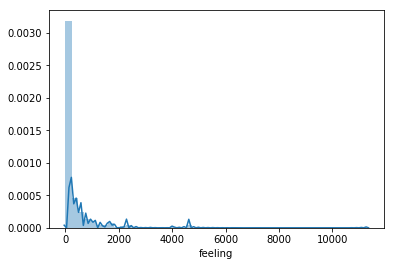

In [8]:
sns.distplot(result.feeling)

I would like to see what are the hashtags using in each tweet

In [9]:
hashtags_array = []

for i in result.text:
    for t in i.strip("#").split():
        if t.startswith("#"):
            if t in hashtags_array:
                pass
            else:
                hashtags_array.append(t)

In [10]:
len(hashtags_array)

8538

Our tweets have 8538 hashtags

Which accounts (@) were called in each tweet?

In [11]:
arroba_array = []

for i in result.text:
    for t in i.strip("@").split():
        if t.startswith("@"):
            if t in arroba_array:
                pass
            else:
                arroba_array.append(t)

In [12]:
len(arroba_array)

14504

We have 14504 accounts used for all the tweets analyzed

According to our researching results, I will make a category for each hashtags

In [13]:
categories = ["#votoutilPabloCasado", "#votoPP", "#110compromisosPSOE", "#Sanchismo", "#Politicautil", "#JuntosSomosImparables",
              "#ciudadanos", "#LaHistoriaLaEscribesTu", "#Podemos", "#UnidasPodemos", "#EspañaViva", "#VOX", 
              "#CatalunaPorEspaña", "#LlibertatPresosPolitics", "#JoAcuso", "#28A", "#28Abril", "#EspanaVaciada",
              "#hazquepase", "#HazQuePaseYNoVuelva", "#HazQueNoPase", "#SanchezMentiroso", "#porEspaña", 
              "#EleccionesGenerales28Abril", "#Casado", "#AlbertRivera", "#PedroSanchez", "#pabloIglesias",
              "#Abascal", "#AbascalPresidente", "#jonqueras", "#ObjetivoRivera", "#VamosCiudadanos", 
              "#CaféAbascal"
]

In [14]:
len(categories)

34

In [15]:
result2 =  result.copy()
for i in categories:
    result2[i] = False

In [16]:
result2["focus"] = ""
for i in categories:
    result2.loc[result2['text'].str.contains(i), i] = True   
    result2.loc[result2['text'].str.contains(i), "focus"] = i 

In [17]:
pd.crosstab(result2.loc[:,"#Casado"], 
            result2.loc[:,"#Casado"])

#Casado,False,True
#Casado,,
False,317905,0
True,0,2510


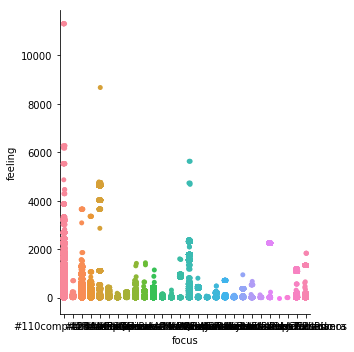

In [18]:
sns.catplot(y='feeling', x='focus', data=result2)

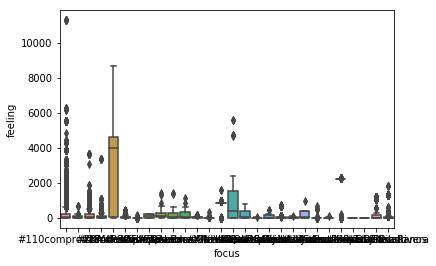

In [19]:
sns.boxplot(y='feeling', x='focus', data=result2)

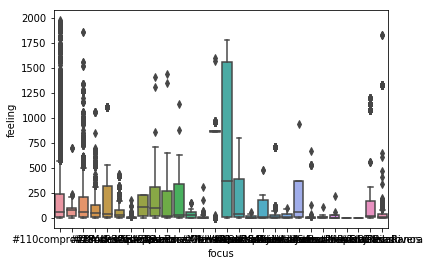

In [20]:
sns.boxplot(y='feeling', x='focus', data=result2[result2.feeling<=2000])

I'm going to take a set registers, especially, which are in the tail of less feeling and the top of high feeling.

In [21]:
less_feeling = result2[result2.feeling <=250].copy()
high_feeling = result2[result2.feeling > 250].copy()

In [24]:
#high_feeling.text.values[14]
high_feeling.text.values[30]

'RT @PSOE: / Queremos que Espaa conquiste su futuro.\r\n\r\n1 La Espaa del conocimiento\r\n2 La Espaa competitiva\r\n3 La Espaa del bienestar'

In the previous example, we can see a problem on our data, which have words that don't have the letters ñ and ',  this might affect the next predictions due in Spanish, in order to solve it we will go to the R code and get again the information

## Number of Words

In [12]:
result2['word_count'] = result2['text'].apply(lambda x: len(str(x).split(" ")))
result2[["text", "word_count"]].head(5)

,text,word_count
0,RT @FmartineL: Reparar a las vctimas de la gue...,27
1,RT @POCHY1971: Esperando a encontrar algo sobr...,17
2,RT @FmartineL: La nica garanta que tiene este ...,25
3,RT @gomezdcelis: Tienes el poder de cambiar la...,23
4,RT @gomezdcelis: Tienes el poder de cambiar la...,23


## Number of Uppercase words

Anger or rage is quiter often expresed by writing UPPERCASE words

In [52]:
result2['upper'] = result2['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [54]:
result2[['text','upper']].head()

,text,upper
0,RT @FmartineL: Reparar a las vctimas de la gue...,1
1,RT @POCHY1971: Esperando a encontrar algo sobr...,2
2,RT @FmartineL: La nica garanta que tiene este ...,1
3,RT @gomezdcelis: Tienes el poder de cambiar la...,2
4,RT @gomezdcelis: Tienes el poder de cambiar la...,2


## Pre-processing 

+ lower case 

In [55]:
result2['text'] = result2['text'].apply(lambda x: "".join(x.lower() for i in x.split()))

In [56]:
result2['text'].head()

0    rt @fmartinel: reparar a las vctimas de la gue...
1    rt @pochy1971: esperando a encontrar algo sobr...
2    rt @fmartinel: la nica garanta que tiene este ...
3    rt @gomezdcelis: tienes el poder de cambiar la...
4    rt @gomezdcelis: tienes el poder de cambiar la...
Name: text, dtype: object

+ Removing puntuation

In [57]:
result2['text'] = result2['text'].str.replace('[^\w\s]', '')
result2['text'].head()

0    rt fmartinel reparar a las vctimas de la guerr...
1    rt pochy1971 esperando a encontrar algo sobre ...
2    rt fmartinel la nica garanta que tiene este pa...
3    rt gomezdcelis tienes el poder de cambiar las ...
4    rt gomezdcelis tienes el poder de cambiar las ...
Name: text, dtype: object

## Remove Stop Words

Let's remove the stop words in Spanish.

In [60]:
from nltk.corpus import stopwords

stop = stopwords.words('spanish')

In [64]:
result2['text'] = result2['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [65]:
result2['text'].head()

0    rtfmartinelrepararvctimasguerrafranquismosacar...
1    rtpochy1971esperandoencontrarsosprisiones110co...
2    rtfmartinelnicagarantapasavanceprogresosensate...
3    rtgomezdcelispodercambiarcosasaunquecreas28a11...
4    rtgomezdcelispodercambiarcosasaunquecreas28a11...
Name: text, dtype: object

## References

+ https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
+ https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
+ https://monkeylearn.com/sentiment-analysis/
+ https://rpubs.com/JaimeFC/415349